## What does CLIP look at in an image?

In [161]:
import clip
import torch
import PIL
from torchvision.transforms import ToPILImage, ToTensor

In [162]:
to_pil = ToPILImage()
to_tensor = ToTensor()

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"
    
print(f"Running on device={device}")

Running on device=mps


In [4]:
model_32, _ = clip.load("ViT-B/32", device=device)

In [5]:
model_16, preprocess = clip.load("ViT-B/16", device=device)

In [6]:
image_model_32 = model_32.visual.eval()
image_model_16 = model_16.visual.eval()

In [7]:
image_model_32

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

In [8]:
image_model_16

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

In [9]:
test_image_path = "../data/dog_princeton.jpg"

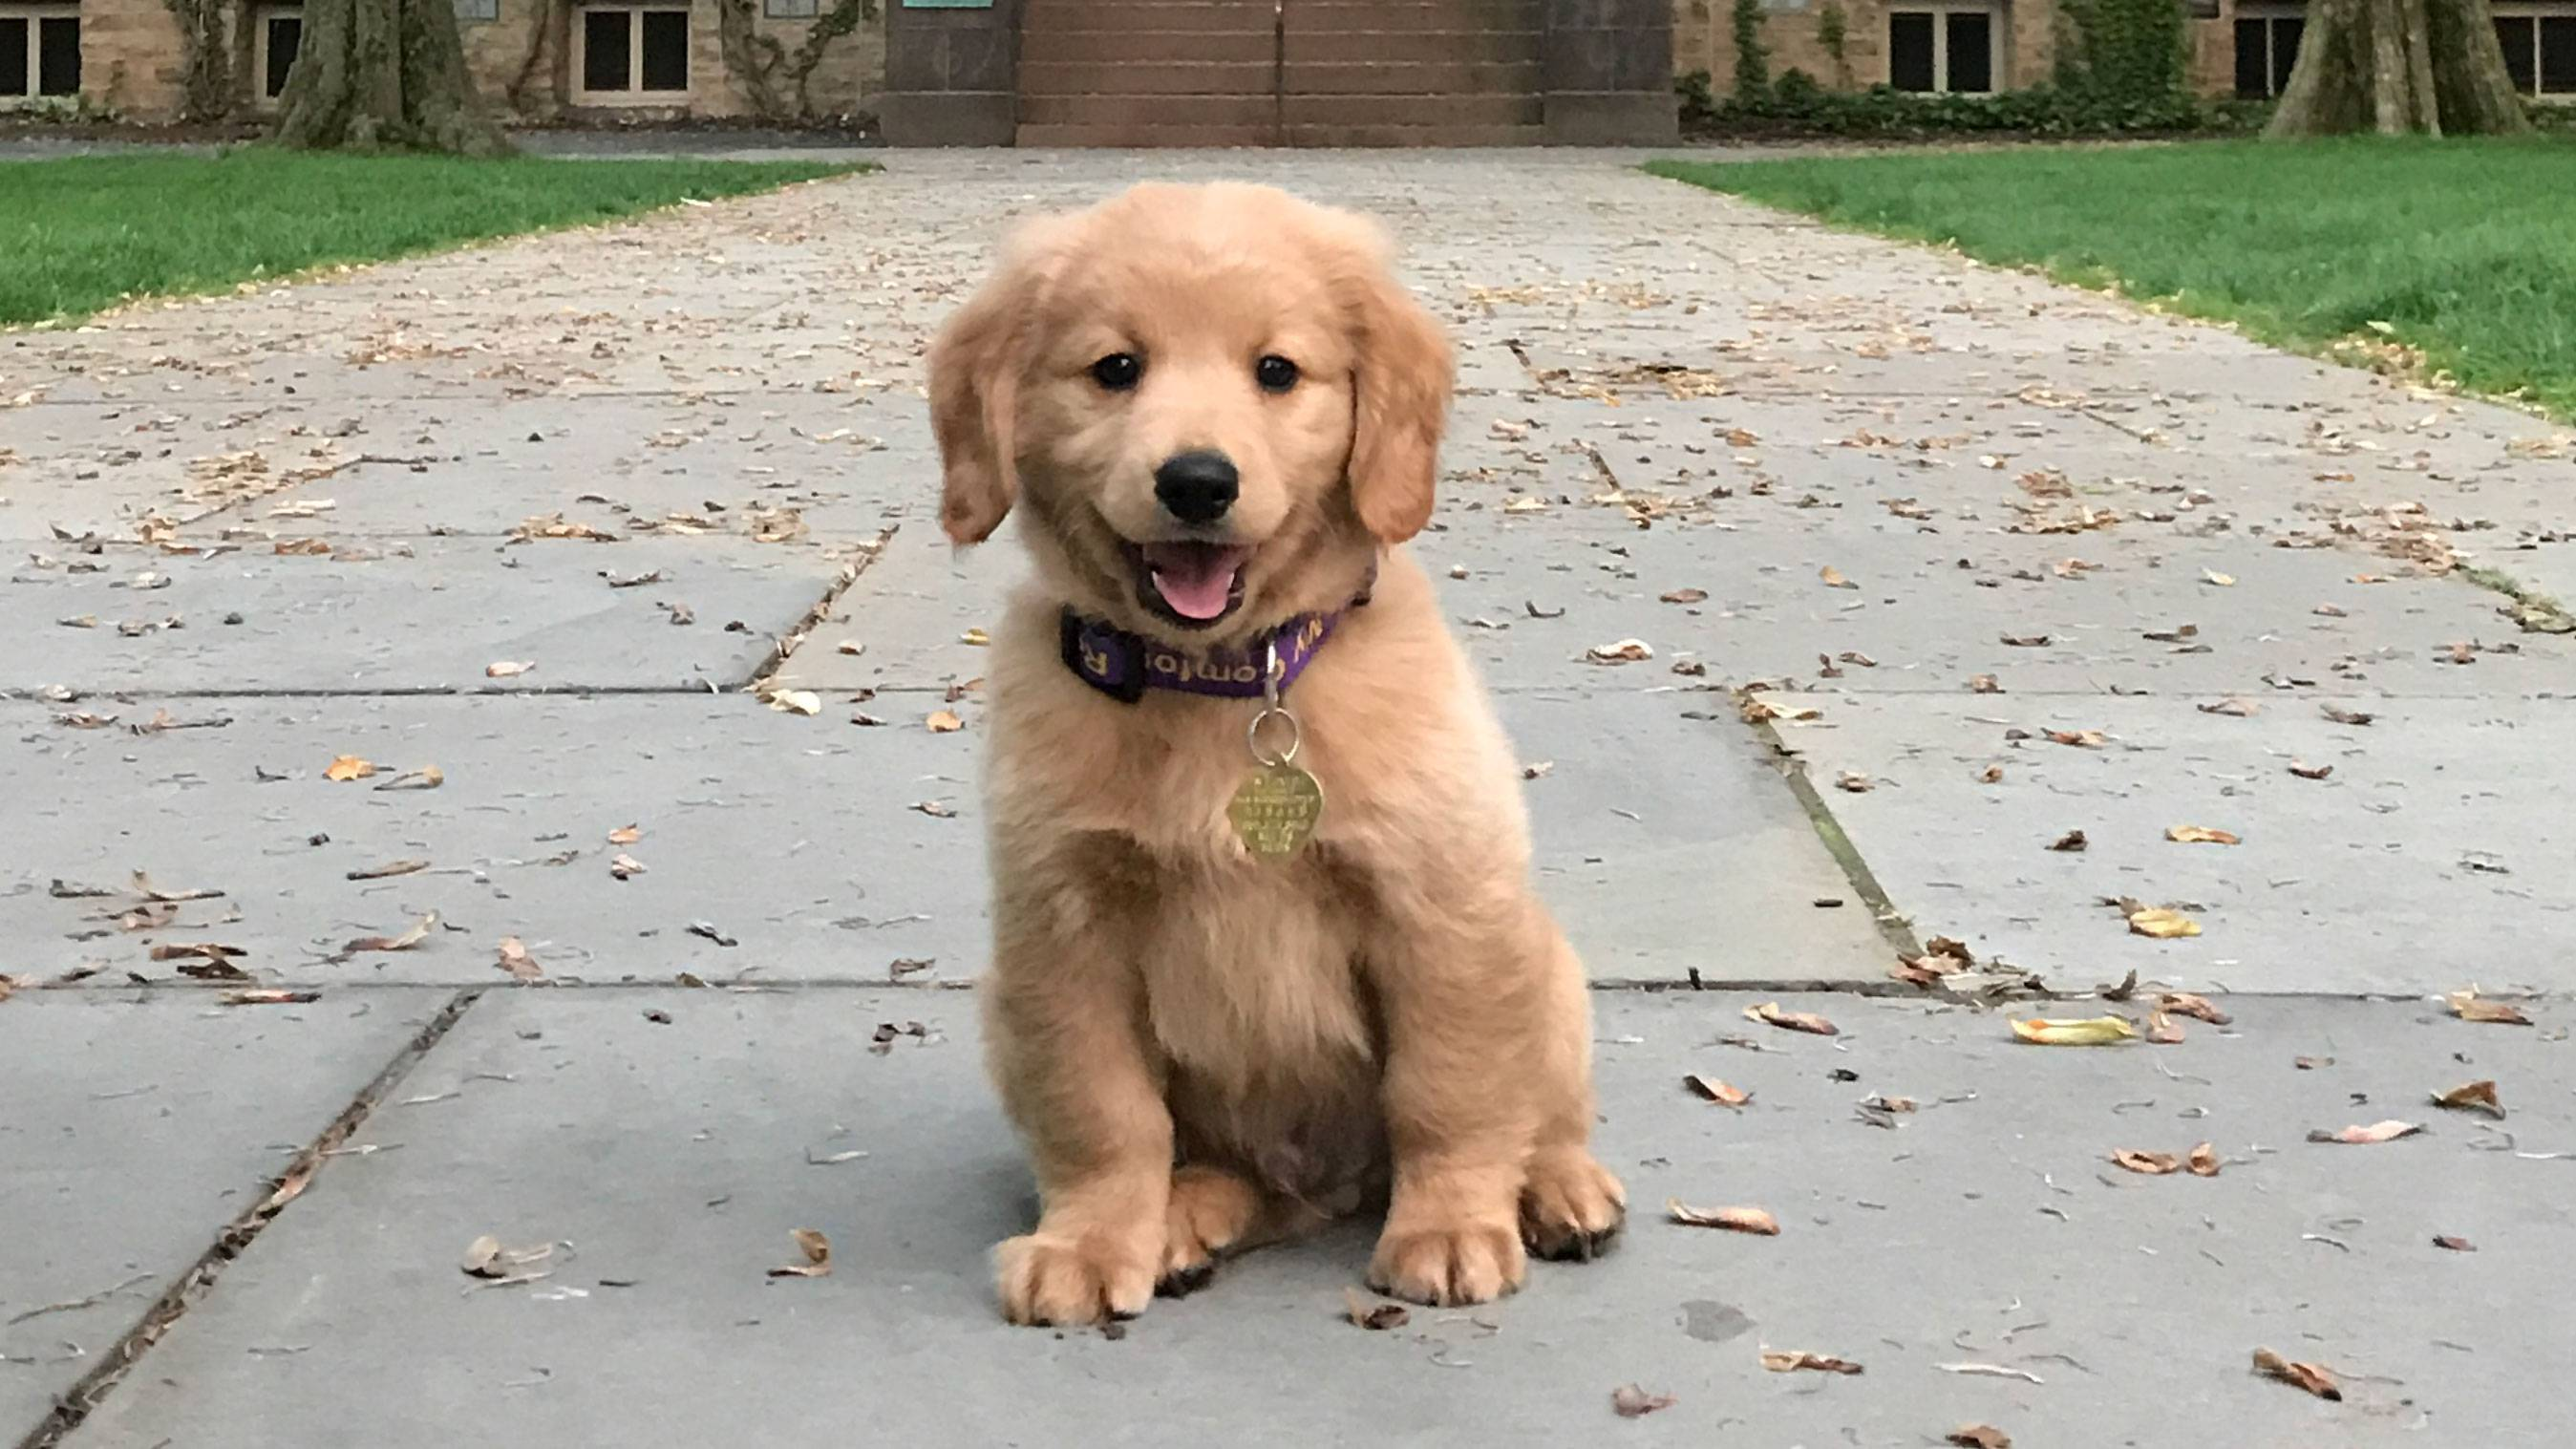

In [10]:
test_image = PIL.Image.open(test_image_path)
test_image

In [11]:
processed_image  = preprocess(test_image)

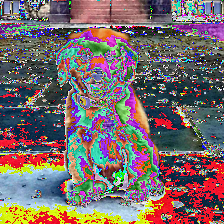

In [12]:
to_pil(processed_image)

In [13]:

processed_image = processed_image \
                           .unsqueeze(0) \
                           .to(device) \
                           .half()

In [14]:
image_embedding = image_model_32(processed_image)

In [15]:
image_embedding.shape

torch.Size([1, 512])

In [16]:
image_embedding.device

device(type='mps', index=0)

### Lets take a look at the convolution layer

In [17]:
image_model_16.conv1

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)

In [18]:
conv1_output = image_model_16.conv1(processed_image)

In [19]:
image_model_16.parameters


<bound method Module.parameters of VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): Layer

In [20]:
image_model_16.conv1.weight.shape

torch.Size([768, 3, 16, 16])

In [21]:
conv1_weight_single = image_model_16.conv1.weight[500]

In [22]:
def fit_to_range(input_tensor, max_value):
    return (input_tensor - input_tensor.min())/ \
                   (input_tensor.max()-input_tensor.min())*max_value
    
    
    
conv1_weight_255 = fit_to_range(conv1_weight_single, 255)

In [23]:
conv1_weight_255.max(), conv1_weight_255.min()

/Users/abdulkarim/Library/Caches/pypoetry/virtualenvs/clip-explainer-On1aimVH-py3.9/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


(tensor(255., device='mps:0', dtype=torch.float16, grad_fn=<MaxBackward1>),
 tensor(0., device='mps:0', dtype=torch.float16, grad_fn=<MinBackward1>))

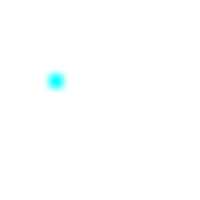

In [24]:
im = to_pil(conv1_weight_255)
im.resize((200,200))

### Lets take a look at attention outputs

In [25]:
image_model_16.transformer.resblocks[0]

ResidualAttentionBlock(
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (gelu): QuickGELU()
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [26]:
14*14

196

In [27]:
image_model_16.transformer.resblocks[1]

ResidualAttentionBlock(
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (gelu): QuickGELU()
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [28]:
image_model_16.transformer.width

768

In [29]:
image_model_16.transformer.resblocks[0].attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)

In [30]:
image_model_16.transformer.resblocks[0].attn.in_proj_weight.shape

torch.Size([2304, 768])

In [31]:
2304

2304

In [79]:
from torch.nn.functional import linear
from math import sqrt
def pre_transformer_output(image, image_model):
    x = image_model.conv1(image)  # shape = [*, width, grid, grid]
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
    x = torch.cat([image_model.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + image_model.positional_embedding.to(x.dtype)
    x = image_model.ln_pre(x)

    x = x.permute(1, 0, 2)  # NLD -> LND
    return x
    
def get_attention_output(image, image_model, residual_layer_index=1):
    x = pre_transformer_output(image, image_model)
    print(x.shape)
    attn_output, attn_weights = image_model.transformer.resblocks[residual_layer_index].attn(x, x, x,average_attn_weights=False)
    return x, attn_output, attn_weights

def get_attention_filter(image, image_model, residual_layer_index=1):
    """computing softmax(Q.K'/sqrt(dim))"""
    x = pre_transformer_output(image, image_model)
    print(x.shape)
    
    q, k, v = 3*[x]
    
    # refer https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention
    # NOTE: This is still not right. the attention should have multiple heads,
    # maybe the projection weights are somehow concatenated?
    projection_weight = image_model.transformer.resblocks[0].attn.in_proj_weight
    projection_bias = image_model.transformer.resblocks[0].attn.in_proj_bias
    
    print(projection_bias.shape)
    q_proj = linear(q, projection_weight, projection_bias)
    k_proj = linear(q, projection_weight, projection_bias)
    num_tokens, _, feature_dimention = k_proj.shape
    
    # converting num_tokens, 1, feature_dimention  --> num_tokens, feature_dimention
    q_proj = q_proj.reshape(num_tokens, feature_dimention)
    k_proj = k_proj.reshape(num_tokens, feature_dimention)
    
    # ignore first token (class token)
    q_proj = q_proj[1:]
    k_proj = k_proj[1:]
    
    attention_filter = torch.mm(q_proj,k_proj.T)/ sqrt(feature_dimention)
    
    attention_filter = attention_filter.softmax(dim=0)

    return attention_filter

In [64]:
attention_filter = get_attention_filter(processed_image, image_model_16)

torch.Size([197, 1, 768])
torch.Size([2304])


In [61]:
attention_filter.shape

torch.Size([196, 196])

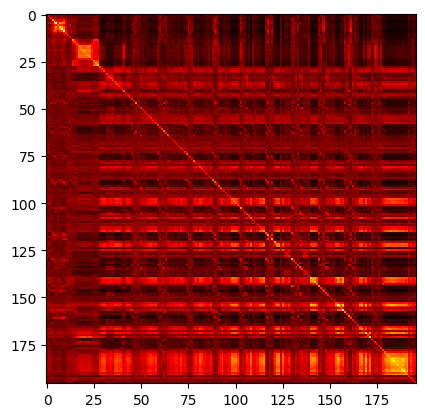

In [62]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(attention_filter.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [80]:
attn_input, attn_output, attn_weights = get_attention_output(processed_image, image_model_16)

torch.Size([197, 1, 768])


In [81]:
# attn_weights are softmax(q.k'/sqrt(dim_k)) for each attention head
attn_output.shape, attn_weights.shape, attn_input.shape

(torch.Size([197, 1, 768]),
 torch.Size([1, 12, 197, 197]),
 torch.Size([197, 1, 768]))

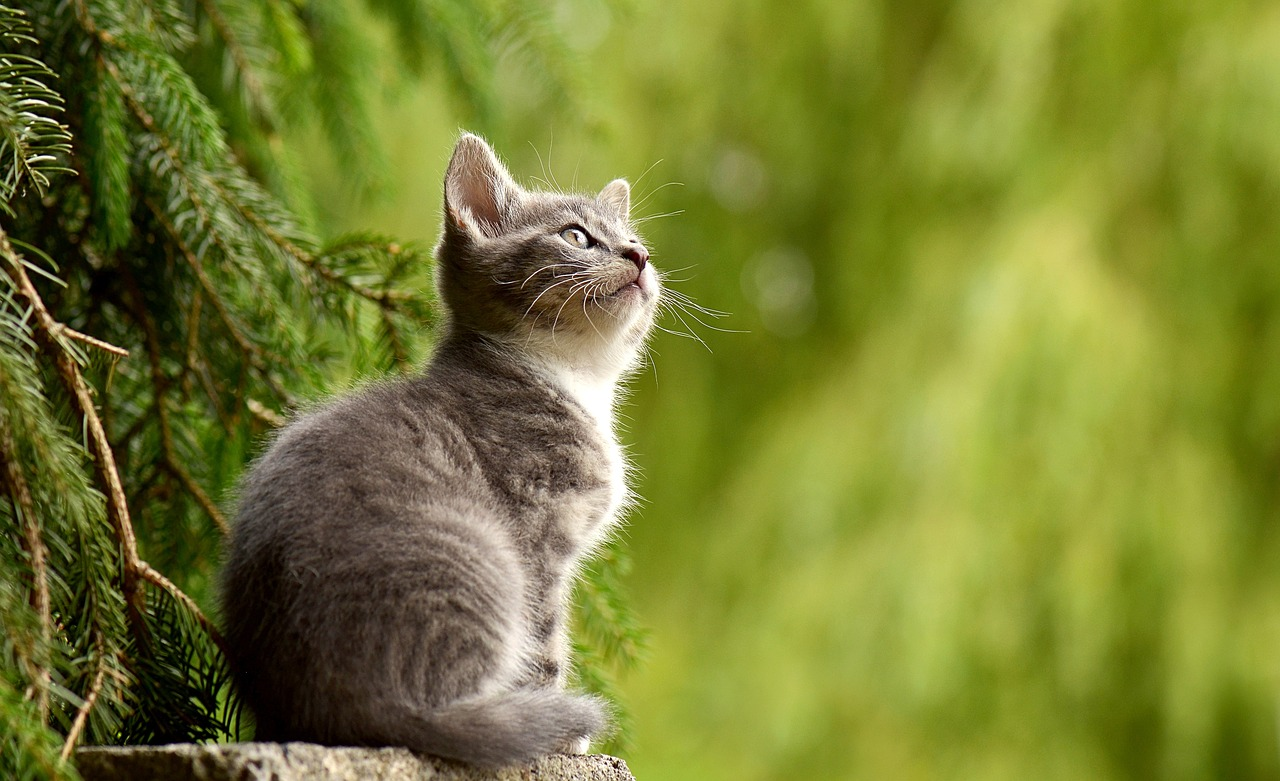

In [227]:
#test_image_path = "../data/dog_princeton.jpg"
test_image_path = "../data/cat-2083492_1280.jpg"
test_image = PIL.Image.open(test_image_path)
test_image

In [228]:
processed_image  = preprocess(test_image)
processed_image = processed_image \
                           .unsqueeze(0) \
                           .to(device) \
                           .half()

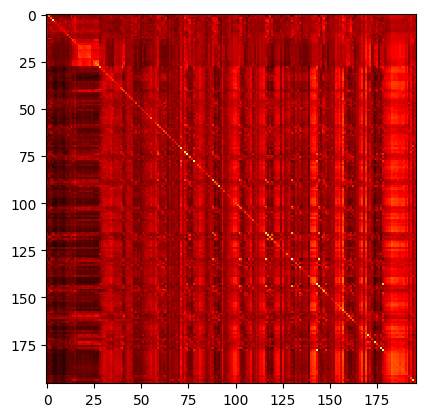

In [229]:
import matplotlib.pyplot as plt
import numpy as np
# ignoring class dimention at the top
plt.imshow(attn_weights[0,0,1:,1:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

torch.Size([197, 1, 768])


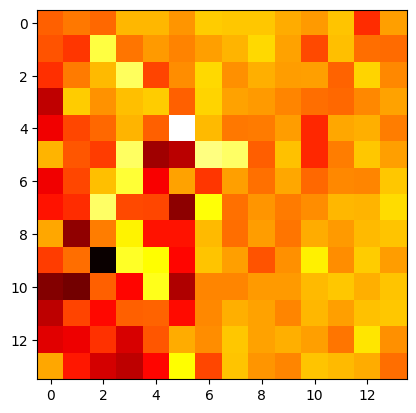

In [230]:
import matplotlib.pyplot as plt
import numpy as np

residual_layer_index = 0
attention_head_index = 0
channel_index = 0

attn_input, attn_output, attn_weights = get_attention_output(processed_image, 
                                                             image_model_16,
                                                             residual_layer_index=residual_layer_index)
attention_weight_singlehead = attn_weights[0][attention_head_index] # softmax(q.k')
attention_input_singlechannel = attn_input[:,:,channel_index] # shape: num_tokens, 1, num_channels

filter_out = torch.mm(attention_weight_singlehead, attention_input_singlechannel)
# ignoring class dimention at the top
# this is a representation of what patches (tokens) the attention head is attending to
filter_out = filter_out[1:,0].reshape(14,14) # ignore the first class token

plt.imshow(filter_out.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

torch.Size([197, 1, 768])


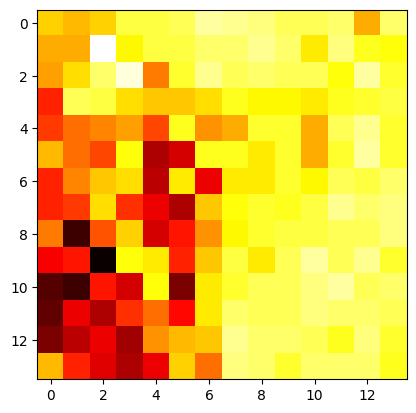

In [231]:

attn_input, attn_output, attn_weights = get_attention_output(processed_image, 
                                                             image_model_16,
                                                             residual_layer_index=residual_layer_index)

average_attn_weight = attn_weights[0].mean(dim=0)
filter_out = torch.mm(average_attn_weight, attention_input_singlechannel)
# ignoring class dimention at the top
# this is a representation of what patches (tokens) the attention head is attending to
filter_out = filter_out[1:,0].reshape(14,14) # ignore the first class token

plt.imshow(filter_out.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

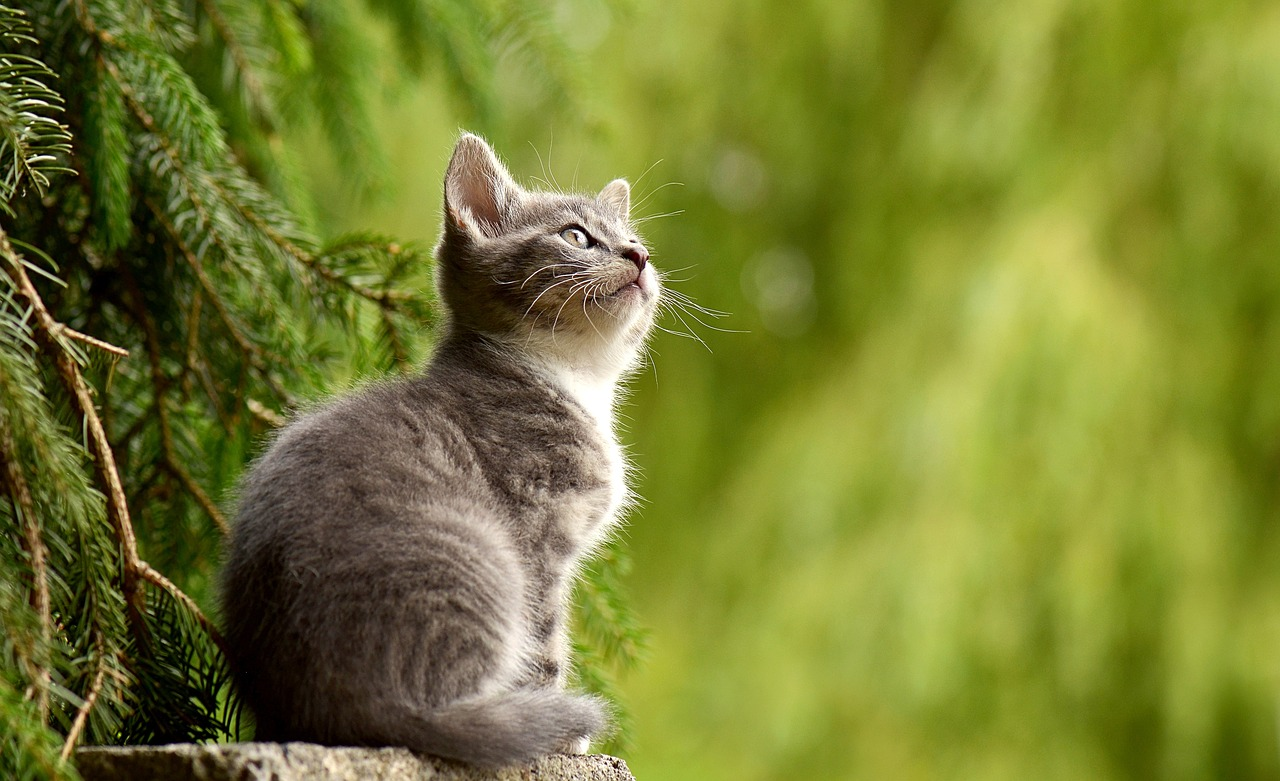

In [232]:
test_image

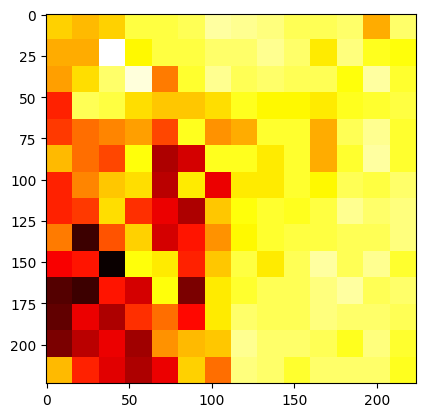

In [233]:
# since the image above is 14*14, expanding each single token to its original 16*16 patch
# this is accomplished by just repeating each filter value
# or by applying each filter value output to 16*16 patches in the original image

# using average attention weights across head, remeber! weight here = softmax(q.k')

filter_out_expanded=filter_out.reshape(14,14,1).repeat(1,16,16).reshape(224,224)
#filter_out.reshape(14,14,1).repeat_interleave(16*16,dim=2).view(224,224)
plt.imshow(filter_out_expanded.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

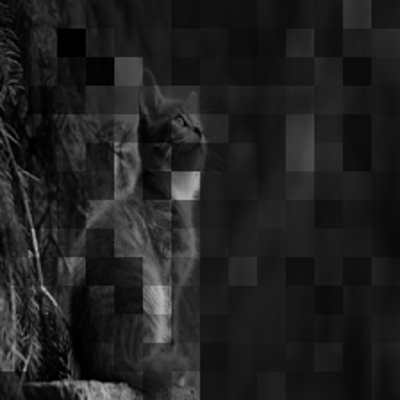

In [234]:
filter_out_expanded_range = 1-fit_to_range(filter_out_expanded, 1)
test_image_reshaped = test_image.resize((224,224)).convert('L')
test_image_reshaped = to_tensor(test_image_reshaped).reshape(224,224).to(device)
filter_overlay_image = test_image_reshaped * filter_out_expanded_range
to_pil(filter_overlay_image).resize((400,400))

In [167]:
to_tensor(test_image_reshaped).reshape(224,224).shape

torch.Size([224, 224])

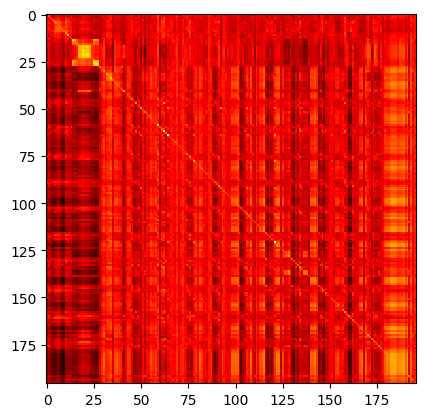

In [75]:
plt.imshow(attn_weights[0,1,1:,1:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

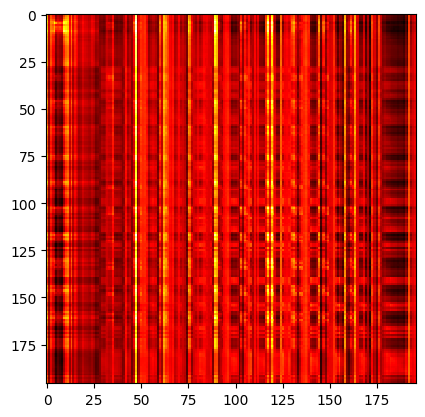

In [76]:
plt.imshow(attn_weights[0,2,1:,1:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

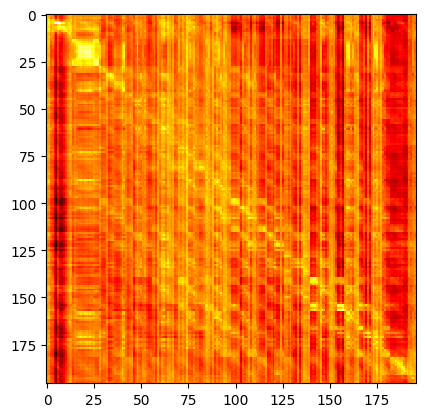

In [77]:
plt.imshow(attn_weights[0,5,1:,1:].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
attn_output[:,:,0].shape

In [ ]:
attn_output[1:,:,0].shape # ignore the first class embedding, focus on one channel for now

In [ ]:
attn_output[1:,:,0].reshape(14,14).shape

In [ ]:
attn_output.mean(dim=2).shape

In [ ]:
# ignoring class embedding, looking at attention output for a single head
# and a single channel


a = attn_output[1:,:,2].reshape(14,14).cpu().detach().numpy()
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
# ignoring class embedding, looking at attention output for a single head
# and mean across all channels
a = attn_output.mean(dim=2)[1:,:].reshape(14,14).cpu().detach().numpy()
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
test_image

In [ ]:
768 // 64